In [1]:
import pandas as pd

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [6]:
from sqlalchemy import create_engine

In [4]:
pd.set_option('display.max_columns', 200)

In [5]:
pd.set_option('display.width', 200)

In [37]:
path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [38]:
df = pd.read_csv(path)

In [40]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [41]:
df.shape

(7043, 21)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [43]:
df.columns = [c.strip().lower() for c in df.columns]

In [45]:
df.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure', 'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling', 'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [46]:
df['customerid'].nunique()

7043

In [47]:
df.shape[0] - df['customerid'].nunique()

0

In [48]:
missing = df.isnull().mean().sort_values(ascending = False)

In [49]:
missing[missing > 0]

Series([], dtype: float64)

In [50]:
df['churn_flag'] = (df['churn'].str.strip().str.lower() == 'yes').astype(int)

In [52]:
df['totalcharges'] = (
    df['totalcharges']
    .astype(str)
    .str.strip()
    .replace({"":np.nan," ":np.nan})
)

In [53]:
df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors = 'coerce')

In [54]:
round(df['churn_flag'].mean()*100,2)

np.float64(26.54)

In [55]:
kpi = {
    'n_customers': int(df.shape[0]),
    'churn_rate_pct': round(df['churn_flag'].mean()*100,2),
    'avg_monthly_charges': round(df['monthlycharges'].mean(),2),
    'monthly_revenue_proxy': round(df['monthlycharges'].sum(),2),
    'monthly_revenue_lost_proxy':round(df.loc[df['churn_flag'] ==1,'monthlycharges'].sum(),2),
}

In [56]:
kpi

{'n_customers': 7043,
 'churn_rate_pct': np.float64(26.54),
 'avg_monthly_charges': np.float64(64.76),
 'monthly_revenue_proxy': np.float64(456116.6),
 'monthly_revenue_lost_proxy': np.float64(139130.85)}

In [57]:
def churn_table(col):
    out = (
        df.groupby(col)
        .agg(
            n = ('customerid', 'size'),
            churn_rate = ('churn_flag', 'mean'),
            avg_monthly = ('monthlycharges', 'mean')
        )
        .reset_index()
    )
    out['churn_rate'] = (out['churn_rate']*100).round(2)
    out['avg_monthly'] = out['avg_monthly'].round(2)
    return out.sort_values('churn_rate', ascending = False)

In [58]:
contract_tbl = churn_table('contract')

In [59]:
payment_tbl = churn_table('paymentmethod')

In [60]:
internet_tbl = churn_table('internetservice')

In [61]:
contract_tbl, payment_tbl, internet_tbl

(         contract     n  churn_rate  avg_monthly
 0  Month-to-month  3875       42.71        66.40
 1        One year  1473       11.27        65.05
 2        Two year  1695        2.83        60.77,
                paymentmethod     n  churn_rate  avg_monthly
 2           Electronic check  2365       45.29        76.26
 3               Mailed check  1612       19.11        43.92
 0  Bank transfer (automatic)  1544       16.71        67.19
 1    Credit card (automatic)  1522       15.24        66.51,
   internetservice     n  churn_rate  avg_monthly
 1     Fiber optic  3096       41.89        91.50
 0             DSL  2421       18.96        58.10
 2              No  1526        7.40        21.08)

In [62]:
tmp = contract_tbl.sort_values('churn_rate', ascending = False)

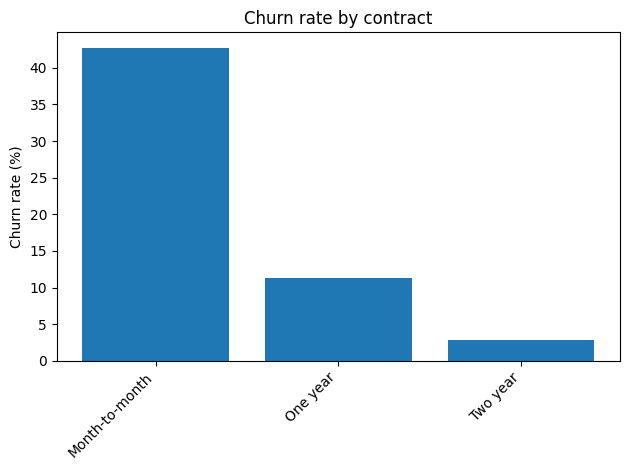

In [63]:
plt.figure()
plt.bar(tmp['contract'], tmp['churn_rate'])
plt.xticks(rotation = 45, ha ='right')
plt.ylabel('Churn rate (%)')
plt.title('Churn rate by contract')
plt.tight_layout()
plt.show()

In [64]:
bins = [-1,12,24,48,10**9]

In [65]:
labels = ['0-12','12-24','24-48','48+']

In [66]:
df['tenure_group'] = pd.cut(df['tenure'], bins = bins, labels=labels)

In [67]:
tenure_tbl = churn_table('tenure_group')

C:\Users\user\AppData\Local\Temp\ipykernel_31708\3456321525.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)


In [68]:
tenure_tbl

,tenure_group,n,churn_rate,avg_monthly
0,0-12,2186,47.44,56.10
1,12-24,1024,28.71,61.36
2,24-48,1594,20.39,65.93
3,48+,2239,9.51,73.95


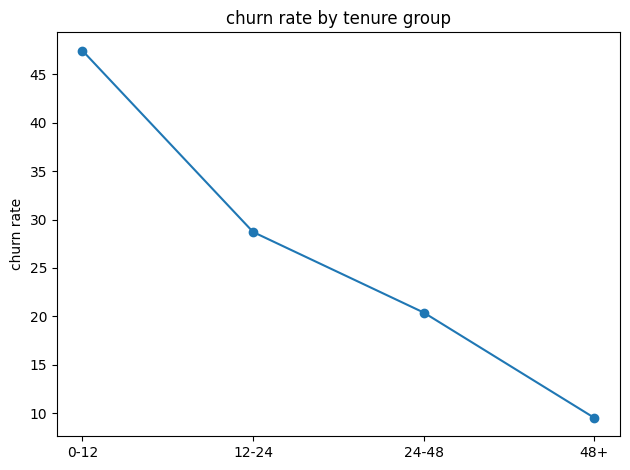

In [70]:
plt.figure()
plt.plot(tenure_tbl['tenure_group'].astype(str), tenure_tbl['churn_rate'], marker = 'o')
plt.ylabel('churn rate')
plt.title('churn rate by tenure group')
plt.tight_layout()
plt.show()

In [71]:
df['high_risk'] = (
    (df['contract'] == 'Month-to-month') &
    (df['tenure'] < 12) &
    (df['monthlycharges'] > 70)
).astype(int)

In [72]:
risk_tbl = (
    df.groupby('high_risk')
    .agg(
        n=('customerid','size'),
        churn_rate = ('churn_flag','mean'),
        avg_monthly = ('monthlycharges','mean')
    )
    .reset_index()
)

In [73]:
risk_tbl['churn_rate'] = (risk_tbl['churn_rate'] *100).round(2)

In [74]:
risk_tbl['avg_monthly'] = risk_tbl['avg_monthly'].round(2)

In [75]:
risk_tbl

,high_risk,n,churn_rate,avg_monthly
0,0,6229,20.92,62.40
1,1,814,69.53,82.82


In [76]:
df['ltv_proxy'] = df['monthlycharges'] * df['tenure']

In [78]:
ltv_tbl = (
    df.groupby('churn_flag')
    .agg(
        n=('customerid','size'),
        ltv_mean = ('ltv_proxy', 'mean'),
        ltv_median = ('ltv_proxy', 'median')
    )
    .reset_index()
)

In [79]:
ltv_tbl['ltv_mean'] = ltv_tbl['ltv_mean'].round(2)

In [80]:
ltv_tbl['ltv_median'] = ltv_tbl['ltv_median'].round(2)

In [81]:
ltv_tbl

,churn_flag,n,ltv_mean,ltv_median
0,0,5174,2549.77,1687.12
1,1,1869,1531.61,700.00


In [82]:
top_loss = (
    df[df['churn_flag'] == 1][['customerid', 'contract', 'paymentmethod', 'tenure','monthlycharges']]
)